# Death rates
The CDC reports deaths per 100,000 people.

In [1]:
import csv
import datetime
import itertools
import math
import os
import pickle
import subprocess
# Imports above are standard library
# Imports below are 3rd-party
import numpy as np
import pandas as pd
import requests
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import RocCurveDisplay, ConfusionMatrixDisplay, recall_score, precision_score, silhouette_score, f1_score, accuracy_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, PredefinedSplit, GridSearchCV
from sklearn.naive_bayes import GaussianNB, BernoulliNB, CategoricalNB, ComplementNB, MultinomialNB
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
from statsmodels.api import qqplot
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.outliers_influence import variance_inflation_factor
import scipy.stats as stats
import statsmodels.api as sm
from xgboost import XGBClassifier, plot_importance

In [2]:
CATEGORY = "category"
IGNORE = "ignore"

## Kaggle API
You will need your own API key, which you can get by following instructions at https://github.com/Kaggle/kaggle-api/blob/main/docs/README.md

In [3]:
os.environ["KAGGLE_USERNAME"] = "jsf80238"
os.environ["KAGGLE_KEY"] = "4036359324650e1c13adfc7ba87ff90e"
import kaggle  # The import itself uses your KAGGLE_KEY, that's why the import is not at the top. Really.

dataset_name = "NCHS - Death Rates and Causes of Death"
command = "kaggle datasets list --csv --search".split()
#command.append("NCHS - Death Rates and Causes of Death")
result = subprocess.run(command + [dataset_name], capture_output=True)
data = result.stdout.decode(encoding="utf-8")
data[:100]

'ref,title,size,lastUpdated,downloadCount,voteCount,usabilityRating\r\ncdc/nchs-death-rates-and-causes-'

In [ ]:
csvreader = csv.DictReader(data.splitlines())
for row in csvreader:
    if row["title"] == dataset_name:
        print(row)
        dataset_ref = row['ref']
        break
dataset_ref

In [ ]:
dataset_ref = "cdc/nchs-death-rates-and-causes-of-death"
file_name = "nchs-leading-causes-of-death-united-states.csv"
command = f"kaggle datasets download --unzip --force --file {file_name} {dataset_ref}".split()
result = subprocess.run(command, capture_output=True)
stdout = result.stdout.decode(encoding="utf-8")
stderr = result.stderr.decode(encoding="utf-8")
print(stdout)
print(stderr)
print(os.linesep.join(sorted(os.listdir("."))))

### Kaggle workaround
If you were unable to download the cause-of-death file you can also grab it from my GitHub repo:

https://github.com/jsf80238/data_science/blob/main/data_files/nchs-leading-causes-of-death-united-states.csv

In [ ]:
df = pd.read_csv(file_name)
df.info()

In [131]:
save_file = "nchs-leading-causes-of-death-united-states.df"
# with open(save_file, "wb") as writer:
#     pickle.dump(df, writer)

with open(save_file, "rb") as reader:
    df = pickle.load(reader)

df

,Year,113 Cause Name,Cause Name,State,Deaths,Age-adjusted Death Rate
0,2012,"Nephritis, nephrotic syndrome and nephrosis (N...",Kidney disease,Vermont,21,2.6
1,2017,"Nephritis, nephrotic syndrome and nephrosis (N...",Kidney disease,Vermont,29,3.3
2,2016,"Nephritis, nephrotic syndrome and nephrosis (N...",Kidney disease,Vermont,30,3.7
3,2013,"Nephritis, nephrotic syndrome and nephrosis (N...",Kidney disease,Vermont,30,3.8
4,2000,"Intentional self-harm (suicide) (*U03,X60-X84,...",Suicide,District of Columbia,23,3.8
...,...,...,...,...,...,...
10863,2001,All Causes,All causes,District of Columbia,5951,1049.9
10864,2002,All Causes,All causes,Mississippi,28853,1051.6
10865,2000,All Causes,All causes,Mississippi,28654,1051.9
10866,2000,All Causes,All causes,District of Columbia,6001,1061.2


In [132]:
YEAR = "year"
CAUSE = "cause_name"
STATE_NAME = "state_name"
DEATH_RATE = "death_rate"
DEATH_RATE_NORMALIZED = "death_rate_normalized"

df.drop(columns=["113 Cause Name", "Deaths"], inplace=True)
name_dict = {
    "Year": YEAR,
    "Cause Name": CAUSE,
    "State": STATE_NAME,
    "Age-adjusted Death Rate": DEATH_RATE,
}
df.rename(columns=name_dict, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10868 entries, 0 to 10867
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   year        10868 non-null  int64  
 1   cause_name  10868 non-null  object 
 2   state_name  10868 non-null  object 
 3   death_rate  10868 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 339.8+ KB


## Adjustments
In case 2017 was an especially good or bad year, use the average from 2010-2017.

Also, eliminate the rows which report deaths for the entire United States.

In [133]:
mask = (df[YEAR] >= 2010) & (df[STATE_NAME] != 'United States')
df = df[mask]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4488 entries, 0 to 10802
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   year        4488 non-null   int64  
 1   cause_name  4488 non-null   object 
 2   state_name  4488 non-null   object 
 3   death_rate  4488 non-null   float64
dtypes: float64(1), int64(1), object(2)
memory usage: 175.3+ KB


In [134]:
df = df[[STATE_NAME, CAUSE, DEATH_RATE]].groupby([STATE_NAME, CAUSE]).mean().reset_index()
df

,state_name,cause_name,death_rate
0,Alabama,All causes,924.6125
1,Alabama,Alzheimer's disease,35.2625
2,Alabama,CLRD,55.5750
3,Alabama,Cancer,180.5125
4,Alabama,Diabetes,22.6875
...,...,...,...
556,Wyoming,Influenza and pneumonia,17.5750
557,Wyoming,Kidney disease,11.7625
558,Wyoming,Stroke,33.2625
559,Wyoming,Suicide,24.6750


## Add a normalized death rate
A state may have a higher death rate across-the-board, or may have a higher death rate for particular causes, or both.

Divide the death rates for particular causes by the death rate for that state to better isolate particular causes.

In [135]:
death_rate_all_causes = "death_rate_all_causes"
all_causes = "All causes"
mask = (df[CAUSE] == all_causes)
by_state_df = df[mask][[STATE_NAME, DEATH_RATE]]
by_state_df

,state_name,death_rate
0,Alabama,924.6125
11,Alaska,739.2125
22,Arizona,678.3625
33,Arkansas,894.7625
44,California,626.4250
55,Colorado,667.9750
66,Connecticut,651.9750
77,Delaware,747.2000
88,District of Columbia,755.1625
99,Florida,671.8875


In [136]:
df = df.merge(by_state_df, on=STATE_NAME, suffixes=(None, "_all_causes"))
df[DEATH_RATE_NORMALIZED] = df[DEATH_RATE] / df[death_rate_all_causes]
df.drop(columns=[death_rate_all_causes], inplace=True)
df

,state_name,cause_name,death_rate,death_rate_normalized
0,Alabama,All causes,924.6125,1.000000
1,Alabama,Alzheimer's disease,35.2625,0.038138
2,Alabama,CLRD,55.5750,0.060106
3,Alabama,Cancer,180.5125,0.195230
4,Alabama,Diabetes,22.6875,0.024537
...,...,...,...,...
556,Wyoming,Influenza and pneumonia,17.5750,0.023672
557,Wyoming,Kidney disease,11.7625,0.015843
558,Wyoming,Stroke,33.2625,0.044801
559,Wyoming,Suicide,24.6750,0.033235


### We don't need all-causes rows anymore

In [137]:
mask = (df[CAUSE] != all_causes)
df = df[mask]
df

,state_name,cause_name,death_rate,death_rate_normalized
1,Alabama,Alzheimer's disease,35.2625,0.038138
2,Alabama,CLRD,55.5750,0.060106
3,Alabama,Cancer,180.5125,0.195230
4,Alabama,Diabetes,22.6875,0.024537
5,Alabama,Heart disease,227.2000,0.245725
...,...,...,...,...
556,Wyoming,Influenza and pneumonia,17.5750,0.023672
557,Wyoming,Kidney disease,11.7625,0.015843
558,Wyoming,Stroke,33.2625,0.044801
559,Wyoming,Suicide,24.6750,0.033235


## Census data
Nonemployer Statistics provides annual statistics on U.S. businesses with no paid employees or payroll at a detailed geography and industry level.

Statistics are available on businesses that have no paid employment or payroll, are subject to federal income taxes, and have receipts of $1,000 or more ($1 or more for the Construction sector). The data are available for approximately 450 NAICS industries at the national, state, county, metropolitan statistical area, and combined statistical area geography levels. The majority of NAICS industries are included.

https://www.census.gov/data/developers/data-sets/nonemp-api.2017.html#list-tab-1358655114

https://www.census.gov/data/developers/data-sets/nonemp-api.html
https://api.census.gov/data/2017/nonemp/variables.html

https://www2.census.gov/programs-surveys/nonemployer-statistics/technical-documentation/record-layouts/state-record-layout/state_record_layout_2017.txt

### Definitions
* LFO = Legal form of organization
* NAICS2017_LABEL = type of business
* NAME = geo areas, including states
* NESTAB = Number of nonemployer establishments
* NRCPTOT = Nonemployer sales, value of shipments, or revenue ($1,000)
* RCPSZES_LABEL = Separates establishments into groups by sales/receipts, including "All establishments"

In [138]:
CENSUS_API_KEY = "35b2edd7f868b6d6f79e5988091d0f8df6ffbd2a"

In [139]:
STATE_KEY = "state_key"
POPULATION = "population"
KEY = "key"
CENSUS_DEMOGRAPHICS_URL = "https://api.census.gov/data/2019/pep/charagegroups"
param_dict = {'get': 'NAME,POP', 'for': 'state:*', KEY: CENSUS_API_KEY}

In [140]:
response = requests.get(CENSUS_DEMOGRAPHICS_URL, params=param_dict)

In [141]:
result_list = response.json()  # The return from the API call is a list of lists, with first item being the column names
column_name_list = result_list.pop(0)
states_df = pd.DataFrame(result_list, columns=column_name_list)
states_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52 entries, 0 to 51
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   NAME    52 non-null     object
 1   POP     52 non-null     object
 2   state   52 non-null     object
dtypes: object(3)
memory usage: 1.3+ KB


In [142]:
name_dict = {
    "NAME": STATE_NAME,
    "POP": POPULATION,
    "state": STATE_KEY,
}
states_df.rename(columns=name_dict, inplace=True)
states_df[POPULATION] = states_df[POPULATION].astype(int)
states_df[STATE_KEY] = states_df[STATE_KEY].astype(int)
states_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52 entries, 0 to 51
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   state_name  52 non-null     object
 1   population  52 non-null     int64 
 2   state_key   52 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 1.3+ KB


In [143]:
states_df[POPULATION].sum()  # Expected value ~330 million

331433217

In [144]:
df = df.merge(states_df, on=STATE_NAME, how="inner")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 510 entries, 0 to 509
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   state_name             510 non-null    object 
 1   cause_name             510 non-null    object 
 2   death_rate             510 non-null    float64
 3   death_rate_normalized  510 non-null    float64
 4   population             510 non-null    int64  
 5   state_key              510 non-null    int64  
dtypes: float64(2), int64(2), object(2)
memory usage: 24.0+ KB


In [145]:
NESTAB = "NESTAB"
NRCPTOT = "NRCPTOT"
LFO = "LFO"
NAICS2017 = "NAICS2017"

CENSUS_NONEMPLOYER_URL = "https://api.census.gov/data/2017/nonemp"
param_dict = {'get': ','.join((LFO, NESTAB, NRCPTOT)), 'for': 'state:*', NAICS2017: '*', KEY: CENSUS_API_KEY}

In [ ]:
# This cell may take a minute or two
response = requests.get(CENSUS_NONEMPLOYER_URL, params=param_dict)

In [ ]:
result_list = response.json()  # The return from the API call is a list of lists, with first item being the column names
column_name_list = result_list.pop(0)
business_df = pd.DataFrame(result_list, columns=column_name_list)
business_df.info()

In [146]:
save_file = "census.df"
# with open(save_file, "wb") as writer:
#     pickle.dump(business_df, writer)

with open(save_file, "rb") as reader:
    business_df = pickle.load(reader)

business_df

,LFO,NESTAB,NRCPTOT,NAICS2017,state
0,001,219596,8889009,00,28
1,9101,1750,206357,00,28
2,9111,6527,848178,00,28
3,920,198380,6220549,00,28
4,930,12939,1613925,00,28
...,...,...,...,...,...
109376,001,4930,58618,813,18
109377,9101,49,1913,813,18
109378,9111,9,360,813,18
109379,920,4864,56215,813,18


In [147]:
LEGAL_FORM = "legal_form"
BUSINESS_TYPE = "business_type"
ESTABLISHMENT_COUNT = "establishment_count"
REVENUE_IN_THOUSANDS = "revenue_in_thousands"
REVENUE_CATEGORY = "revenue_category"
name_dict = {
    "state": STATE_KEY,
    "NAICS2017": BUSINESS_TYPE,
    "LFO": LEGAL_FORM,
    "NESTAB": ESTABLISHMENT_COUNT,
    "NRCPTOT": REVENUE_IN_THOUSANDS,
}
business_df.rename(columns=name_dict, inplace=True)
business_df = business_df.reindex([STATE_KEY, LEGAL_FORM, BUSINESS_TYPE, ESTABLISHMENT_COUNT, REVENUE_IN_THOUSANDS], axis=1)
business_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109381 entries, 0 to 109380
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   state_key             109381 non-null  object
 1   legal_form            109381 non-null  object
 2   business_type         109381 non-null  object
 3   establishment_count   109381 non-null  object
 4   revenue_in_thousands  109381 non-null  object
dtypes: object(5)
memory usage: 4.2+ MB


## Eliminate redudant legal form rows
Census rows with a legal form of "All" ("001") are summaries of the other rows.

In [148]:
mask = (business_df[LEGAL_FORM] != "001")
business_df = business_df[mask]
business_df.shape

(85555, 5)

## Eliminate redudant business type rows
The Census data contains rows for multiple levels, some of which are partially duplicative, for example:
| Code | Name |
| --- | --- |
| 11 | Agriculture, Forestry, Fishing and Hunting |
| 111 | Crop Production |
| 1111 | Oilseed and Grain Farming |
| 11111 | Soybean Farming |
| 111110 | Soybean Farming |
| 11112 | Oilseed (except Soybean) Farming |
| 111120 | Oilseed (except Soybean) Farming |
| 11113 | Dry Pea and Bean Farming |
| 111130 | Dry Pea and Bean Farming |

Although somewhat arbitrary, the 3-digit codes make the most sense to me.

In [149]:
mask = (business_df[BUSINESS_TYPE].str.len() == 3)
business_df = business_df[mask]
business_df.shape

(15708, 5)

## Convert numeric-like values to numerics

In [150]:
for column_name in ESTABLISHMENT_COUNT, REVENUE_IN_THOUSANDS, STATE_KEY:
    business_df[column_name] = business_df[column_name].astype(int)
business_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15708 entries, 11 to 109380
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   state_key             15708 non-null  int64 
 1   legal_form            15708 non-null  object
 2   business_type         15708 non-null  object
 3   establishment_count   15708 non-null  int64 
 4   revenue_in_thousands  15708 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 736.3+ KB


In [151]:
business_df

,state_key,legal_form,business_type,establishment_count,revenue_in_thousands
11,28,9101,113,19,2091
12,28,9111,113,53,7736
13,28,920,113,1284,72984
14,28,930,113,70,8958
16,28,9101,114,36,5920
...,...,...,...,...,...
109289,18,930,812,648,58468
109377,18,9101,813,49,1913
109378,18,9111,813,9,360
109379,18,920,813,4864,56215


## Check for duplicate rows

In [152]:
mask = business_df[[STATE_KEY, BUSINESS_TYPE, LEGAL_FORM]].duplicated()
business_df[mask]

,state_key,legal_form,business_type,establishment_count,revenue_in_thousands


## Check for holes
Verify this data does not have holes, meaning verify every combination of legal_form/business_type exists for every state.

If something is missing, add it with np.nan for the establishment_count and revenue.

In [153]:
state_list = business_df[STATE_KEY].unique()
legal_form_list = business_df[LEGAL_FORM].unique()
business_type_list = business_df[BUSINESS_TYPE].unique()
wanted_combinations_set = set(itertools.product(state_list, legal_form_list, business_type_list))
print(f"{len(wanted_combinations_set):,} possible combinations, for example:")
for i, item in enumerate(wanted_combinations_set):
    print(item)
    if i > 10:
        break


16,728 possible combinations, for example:
(8, '930', '533')
(56, '9101', '561')
(9, '920', '453')
(32, '920', '515')
(36, '920', '221')
(51, '930', '424')
(19, '9111', '493')
(39, '9101', '492')
(25, '9111', '333')
(18, '9111', '113')
(33, '9101', '524')
(32, '930', '446')


In [154]:
existing_combinations_set = set()
for item in business_df[[STATE_KEY, LEGAL_FORM, BUSINESS_TYPE]].to_records(index=False):
    existing_combinations_set.add(tuple(item))
print(f"{len(existing_combinations_set):,} existing combinations, for example:")
for i, item in enumerate(existing_combinations_set):
    print(item)
    if i > 10:
        break

15,708 existing combinations, for example:
(8, '930', '533')
(56, '9101', '561')
(9, '920', '453')
(36, '920', '221')
(32, '920', '515')
(51, '930', '424')
(19, '9111', '493')
(39, '9101', '492')
(25, '9111', '333')
(18, '9111', '113')
(33, '9101', '524')
(32, '930', '446')


In [155]:
missing_combinations_set = wanted_combinations_set - existing_combinations_set
print(f"{len(missing_combinations_set):,} missing combinations, for example:")
for i, item in enumerate(missing_combinations_set):
    print(item)
    if i > 10:
        break

1,020 missing combinations, for example:
(56, '930', '313')
(20, '9101', '533')
(5, '9101', '316')
(28, '930', '313')
(56, '9101', '313')
(35, '930', '322')
(40, '9101', '313')
(47, '9101', '322')
(20, '9111', '483')
(33, '9101', '213')
(10, '9111', '312')
(54, '9111', '314')


In [156]:
missing_data = [list(combo) + [np.nan, np.nan] for combo in missing_combinations_set]
missing_data[:10]

[[56, '930', '313', nan, nan],
 [20, '9101', '533', nan, nan],
 [5, '9101', '316', nan, nan],
 [28, '930', '313', nan, nan],
 [56, '9101', '313', nan, nan],
 [35, '930', '322', nan, nan],
 [40, '9101', '313', nan, nan],
 [47, '9101', '322', nan, nan],
 [20, '9111', '483', nan, nan],
 [33, '9101', '213', nan, nan]]

In [157]:
missing_df = pd.DataFrame.from_records(missing_data)
missing_df.columns = [STATE_KEY, LEGAL_FORM, BUSINESS_TYPE, ESTABLISHMENT_COUNT, REVENUE_IN_THOUSANDS]
missing_df

,state_key,legal_form,business_type,establishment_count,revenue_in_thousands
0,56,930,313,NaN,NaN
1,20,9101,533,NaN,NaN
2,5,9101,316,NaN,NaN
3,28,930,313,NaN,NaN
4,56,9101,313,NaN,NaN
...,...,...,...,...,...
1015,2,930,211,NaN,NaN
1016,2,9101,312,NaN,NaN
1017,1,9101,213,NaN,NaN
1018,11,9101,533,NaN,NaN


In [158]:
business_df = pd.concat([business_df, missing_df], ignore_index=True)
business_df

,state_key,legal_form,business_type,establishment_count,revenue_in_thousands
0,28,9101,113,19.0,2091.0
1,28,9111,113,53.0,7736.0
2,28,920,113,1284.0,72984.0
3,28,930,113,70.0,8958.0
4,28,9101,114,36.0,5920.0
...,...,...,...,...,...
16723,2,930,211,NaN,NaN
16724,2,9101,312,NaN,NaN
16725,1,9101,213,NaN,NaN
16726,11,9101,533,NaN,NaN


## Merge cause of death data with business data

In [159]:
df = df.merge(business_df, on=STATE_KEY, how="inner")
df

,state_name,cause_name,death_rate,death_rate_normalized,population,state_key,legal_form,business_type,establishment_count,revenue_in_thousands
0,Alabama,Alzheimer's disease,35.2625,0.038138,4903185,1,9101,113,13.0,1959.0
1,Alabama,Alzheimer's disease,35.2625,0.038138,4903185,1,9111,113,45.0,7584.0
2,Alabama,Alzheimer's disease,35.2625,0.038138,4903185,1,920,113,1223.0,68217.0
3,Alabama,Alzheimer's disease,35.2625,0.038138,4903185,1,930,113,66.0,13763.0
4,Alabama,Alzheimer's disease,35.2625,0.038138,4903185,1,9101,114,11.0,1517.0
...,...,...,...,...,...,...,...,...,...,...
167275,Wyoming,Unintentional injuries,58.7000,0.079063,578759,56,9101,493,NaN,NaN
167276,Wyoming,Unintentional injuries,58.7000,0.079063,578759,56,9111,336,NaN,NaN
167277,Wyoming,Unintentional injuries,58.7000,0.079063,578759,56,920,322,NaN,NaN
167278,Wyoming,Unintentional injuries,58.7000,0.079063,578759,56,9101,483,NaN,NaN


## Adjust for population
We would expect the number of establishments and revenue to be higher in more populous states.

Adjust.

In [160]:
ESTABLISHMENTS_PP = "establishments_pp"
REVENUE_PP = "revenue_pp"
df[ESTABLISHMENTS_PP] = df[ESTABLISHMENT_COUNT] / df[POPULATION]
df[REVENUE_PP] = df[REVENUE_IN_THOUSANDS] * 1000 / df[POPULATION]
df

,state_name,cause_name,death_rate,death_rate_normalized,population,state_key,legal_form,business_type,establishment_count,revenue_in_thousands,establishments_pp,revenue_pp
0,Alabama,Alzheimer's disease,35.2625,0.038138,4903185,1,9101,113,13.0,1959.0,0.000003,0.399536
1,Alabama,Alzheimer's disease,35.2625,0.038138,4903185,1,9111,113,45.0,7584.0,0.000009,1.546750
2,Alabama,Alzheimer's disease,35.2625,0.038138,4903185,1,920,113,1223.0,68217.0,0.000249,13.912793
3,Alabama,Alzheimer's disease,35.2625,0.038138,4903185,1,930,113,66.0,13763.0,0.000013,2.806951
4,Alabama,Alzheimer's disease,35.2625,0.038138,4903185,1,9101,114,11.0,1517.0,0.000002,0.309391
...,...,...,...,...,...,...,...,...,...,...,...,...
167275,Wyoming,Unintentional injuries,58.7000,0.079063,578759,56,9101,493,NaN,NaN,NaN,NaN
167276,Wyoming,Unintentional injuries,58.7000,0.079063,578759,56,9111,336,NaN,NaN,NaN,NaN
167277,Wyoming,Unintentional injuries,58.7000,0.079063,578759,56,920,322,NaN,NaN,NaN,NaN
167278,Wyoming,Unintentional injuries,58.7000,0.079063,578759,56,9101,483,NaN,NaN,NaN,NaN


## Multicollinearity
Collinearity among indepedent variables is fatal for regression models and not helpful for other models.

<Axes: >

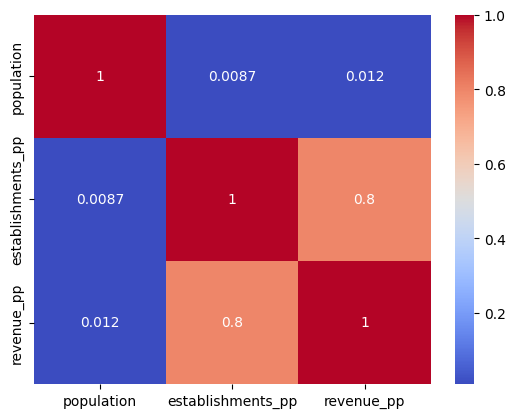

In [161]:
potential_suspects_df = df[[POPULATION, ESTABLISHMENTS_PP, REVENUE_PP]]
correlation_matrix = suspect_columns_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')

The result above means Establishments and Revenue are very highly correlated, so we should not use one.

Perhaps revenue per establishment might be a different, uncorrelated independent variable we could use?

<Axes: >

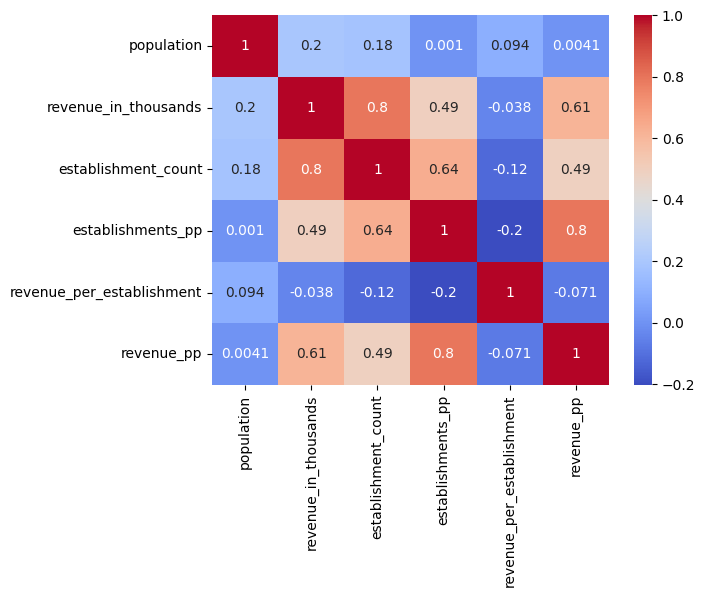

In [162]:
REVENUE_PER_ESTABLISHMENT = "revenue_per_establishment"
df[REVENUE_PER_ESTABLISHMENT] = df[REVENUE_IN_THOUSANDS] * 1000 / df[ESTABLISHMENT_COUNT]

more_suspects_df = df[[POPULATION, REVENUE_IN_THOUSANDS, ESTABLISHMENT_COUNT, ESTABLISHMENTS_PP, REVENUE_PER_ESTABLISHMENT, REVENUE_PP]]
correlation_matrix = more_suspects_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')

We are going to pick 0.6 as the threshold, meaning

we will drop revenue and revenue per person.

In [163]:
df.drop(columns=[REVENUE_IN_THOUSANDS, REVENUE_PP], inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167280 entries, 0 to 167279
Data columns (total 11 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   state_name                 167280 non-null  object 
 1   cause_name                 167280 non-null  object 
 2   death_rate                 167280 non-null  float64
 3   death_rate_normalized      167280 non-null  float64
 4   population                 167280 non-null  int64  
 5   state_key                  167280 non-null  int64  
 6   legal_form                 167280 non-null  object 
 7   business_type              167280 non-null  object 
 8   establishment_count        157080 non-null  float64
 9   establishments_pp          157080 non-null  float64
 10  revenue_per_establishment  141330 non-null  float64
dtypes: float64(5), int64(2), object(4)
memory usage: 14.0+ MB


## Categorization of data
Let's make population, establishment_pp and revenue_pp categories

Distribution plots will help us decide how to make the cuts.

7 for population.
41 for establishments_pp.
46 for revenue_per_establishment.


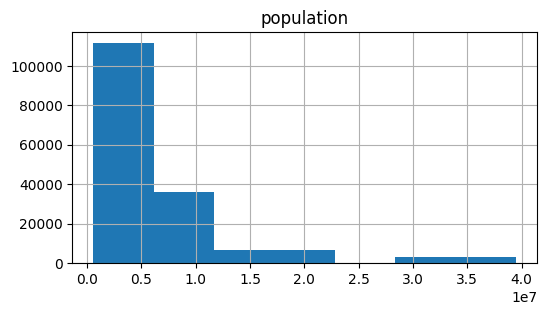

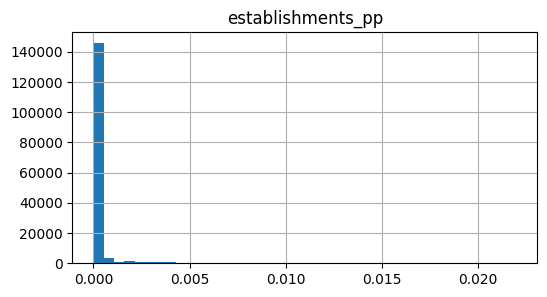

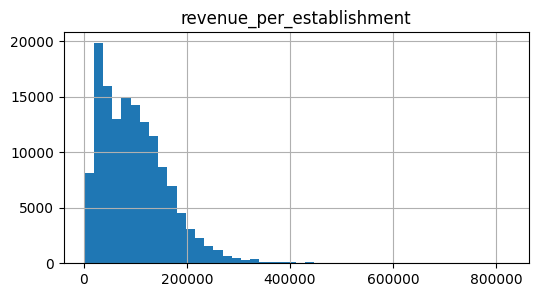

In [164]:
for column_name in POPULATION, ESTABLISHMENTS_PP, REVENUE_PER_ESTABLISHMENT:
    number_of_observations = df[column_name].nunique()
    # Rice's rule
    suggested_bin_count = int(math.cbrt(number_of_observations)*2)
    print(f"{suggested_bin_count} for {column_name}.")
    df.hist(column=column_name, bins=suggested_bin_count, figsize=(6, 3))

## Binning conclusion
Population: 7 cuts based on absolute population

Establishments and revenue per establishment: 7 cuts with equal numbers of observations in each bin

In [167]:
XXSMALL = "xx-small"
XSMALL = "x-small"
SMALL = "small"
MEDIUM = "medium"
LARGE = "large"
XLARGE = "x-large"
XXLARGE = "xx-large"

POPULATION_BIN = "population_bin"
ESTABLISHMENTS_BIN = "establishments_bin"
REVENUE_PER_ESTABLISHMENT_BIN = "revenue_per_establishment_bin"

df[POPULATION_BIN] = pd.cut(df[POPULATION], 7, labels=[XXSMALL, XSMALL, SMALL, MEDIUM, LARGE, XLARGE, XXLARGE])
df[ESTABLISHMENTS_BIN] = pd.qcut(df[ESTABLISHMENTS_PP], 7, labels=[XXSMALL, XSMALL, SMALL, MEDIUM, LARGE, XLARGE, XXLARGE])
df[REVENUE_PER_ESTABLISHMENT_BIN] = pd.qcut(df[REVENUE_PER_ESTABLISHMENT], 7, labels=[XXSMALL, XSMALL, SMALL, MEDIUM, LARGE, XLARGE, XXLARGE])

for column_name in POPULATION_BIN, ESTABLISHMENTS_BIN, REVENUE_PER_ESTABLISHMENT_BIN:
    print(df[column_name].value_counts())

df

population_bin
xx-small    111520
x-small      36080
small         6560
medium        6560
x-large       3280
xx-large      3280
large            0
Name: count, dtype: int64
establishments_bin
xx-small    22510
medium      22450
x-large     22440
xx-large    22440
small       22430
large       22430
x-small     22380
Name: count, dtype: int64
revenue_per_establishment_bin
xx-small    20190
x-small     20190
small       20190
medium      20190
large       20190
x-large     20190
xx-large    20190
Name: count, dtype: int64


,state_name,cause_name,death_rate,death_rate_normalized,population,state_key,legal_form,business_type,establishment_count,establishments_pp,revenue_per_establishment,population_bin,establishments_bin,revenue_per_establishment_bin
0,Alabama,Alzheimer's disease,35.2625,0.038138,4903185,1,9101,113,13.0,0.000003,150692.307692,xx-small,x-small,x-large
1,Alabama,Alzheimer's disease,35.2625,0.038138,4903185,1,9111,113,45.0,0.000009,168533.333333,xx-small,medium,xx-large
2,Alabama,Alzheimer's disease,35.2625,0.038138,4903185,1,920,113,1223.0,0.000249,55778.413737,xx-small,xx-large,small
3,Alabama,Alzheimer's disease,35.2625,0.038138,4903185,1,930,113,66.0,0.000013,208530.303030,xx-small,medium,xx-large
4,Alabama,Alzheimer's disease,35.2625,0.038138,4903185,1,9101,114,11.0,0.000002,137909.090909,xx-small,x-small,x-large
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167275,Wyoming,Unintentional injuries,58.7000,0.079063,578759,56,9101,493,NaN,NaN,NaN,xx-small,NaN,NaN
167276,Wyoming,Unintentional injuries,58.7000,0.079063,578759,56,9111,336,NaN,NaN,NaN,xx-small,NaN,NaN
167277,Wyoming,Unintentional injuries,58.7000,0.079063,578759,56,920,322,NaN,NaN,NaN,xx-small,NaN,NaN
167278,Wyoming,Unintentional injuries,58.7000,0.079063,578759,56,9101,483,NaN,NaN,NaN,xx-small,NaN,NaN


## Set establishments and revenue to 0/XXSMALL where currently NaN
These did not exist at all in the original data, meaning their true value is zero, so XXSMALL is a good category.

In [168]:
df[ESTABLISHMENTS_BIN] = df[ESTABLISHMENTS_BIN].fillna(XXSMALL)
df[REVENUE_PER_ESTABLISHMENT_BIN] = df[REVENUE_PER_ESTABLISHMENT_BIN].fillna(XXSMALL)
df

,state_name,cause_name,death_rate,death_rate_normalized,population,state_key,legal_form,business_type,establishment_count,establishments_pp,revenue_per_establishment,population_bin,establishments_bin,revenue_per_establishment_bin
0,Alabama,Alzheimer's disease,35.2625,0.038138,4903185,1,9101,113,13.0,0.000003,150692.307692,xx-small,x-small,x-large
1,Alabama,Alzheimer's disease,35.2625,0.038138,4903185,1,9111,113,45.0,0.000009,168533.333333,xx-small,medium,xx-large
2,Alabama,Alzheimer's disease,35.2625,0.038138,4903185,1,920,113,1223.0,0.000249,55778.413737,xx-small,xx-large,small
3,Alabama,Alzheimer's disease,35.2625,0.038138,4903185,1,930,113,66.0,0.000013,208530.303030,xx-small,medium,xx-large
4,Alabama,Alzheimer's disease,35.2625,0.038138,4903185,1,9101,114,11.0,0.000002,137909.090909,xx-small,x-small,x-large
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167275,Wyoming,Unintentional injuries,58.7000,0.079063,578759,56,9101,493,NaN,NaN,NaN,xx-small,xx-small,xx-small
167276,Wyoming,Unintentional injuries,58.7000,0.079063,578759,56,9111,336,NaN,NaN,NaN,xx-small,xx-small,xx-small
167277,Wyoming,Unintentional injuries,58.7000,0.079063,578759,56,920,322,NaN,NaN,NaN,xx-small,xx-small,xx-small
167278,Wyoming,Unintentional injuries,58.7000,0.079063,578759,56,9101,483,NaN,NaN,NaN,xx-small,xx-small,xx-small


## Cleanup
We have columns we no longer need.

In [170]:
df.drop(columns=[STATE_KEY, STATE_NAME, ESTABLISHMENT_COUNT], inplace=True)
df

,cause_name,death_rate,death_rate_normalized,population,legal_form,business_type,establishments_pp,revenue_per_establishment,population_bin,establishments_bin,revenue_per_establishment_bin
0,Alzheimer's disease,35.2625,0.038138,4903185,9101,113,0.000003,150692.307692,xx-small,x-small,x-large
1,Alzheimer's disease,35.2625,0.038138,4903185,9111,113,0.000009,168533.333333,xx-small,medium,xx-large
2,Alzheimer's disease,35.2625,0.038138,4903185,920,113,0.000249,55778.413737,xx-small,xx-large,small
3,Alzheimer's disease,35.2625,0.038138,4903185,930,113,0.000013,208530.303030,xx-small,medium,xx-large
4,Alzheimer's disease,35.2625,0.038138,4903185,9101,114,0.000002,137909.090909,xx-small,x-small,x-large
...,...,...,...,...,...,...,...,...,...,...,...
167275,Unintentional injuries,58.7000,0.079063,578759,9101,493,NaN,NaN,xx-small,xx-small,xx-small
167276,Unintentional injuries,58.7000,0.079063,578759,9111,336,NaN,NaN,xx-small,xx-small,xx-small
167277,Unintentional injuries,58.7000,0.079063,578759,920,322,NaN,NaN,xx-small,xx-small,xx-small
167278,Unintentional injuries,58.7000,0.079063,578759,9101,483,NaN,NaN,xx-small,xx-small,xx-small


## Categorize death rates
We need to do this for each cause of death, because they are not really comparable to each other.

7 for Alzheimer's disease.
7 for CLRD.
7 for Cancer.
7 for Diabetes.
7 for Heart disease.
7 for Influenza and pneumonia.
7 for Kidney disease.
7 for Stroke.
7 for Suicide.
7 for Unintentional injuries.


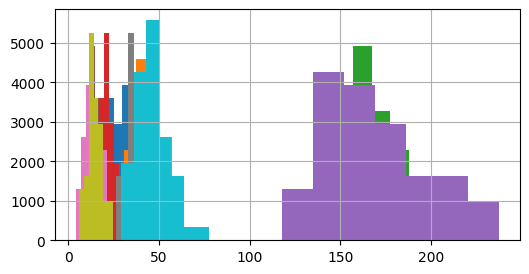

In [171]:
for cause_name in df[CAUSE].unique():
    mask = (df[CAUSE] == cause_name)
    number_of_observations = df[mask][DEATH_RATE].nunique()
    # Rice's rule
    suggested_bin_count = int(math.cbrt(number_of_observations)*2)
    print(f"{suggested_bin_count} for {cause_name}.")
    df[mask][DEATH_RATE].hist(bins=suggested_bin_count, figsize=(6, 3))

In [172]:
DEATH_RATE_BIN = "death_rate_bin"
try:
    df.drop(columns=[DEATH_RATE_BIN], inplace=True)
except KeyError:
    pass

all_labels_df = pd.DataFrame()

for cause_name in df[CAUSE].unique():
    mask = (df[CAUSE] == cause_name)
    cause_labels = pd.qcut(df[mask][DEATH_RATE], 7, labels=[XXSMALL, XSMALL, SMALL, MEDIUM, LARGE, XLARGE, XXLARGE])
    if all_labels_df.size:
        all_labels_df = pd.concat([all_labels_df, cause_labels])
    else:
        all_labels_df = cause_labels

all_labels_df.shape

(167280,)

In [173]:
df = df.merge(all_labels_df, left_index=True, right_index=True, suffixes=(None, "_bin"))
print(df[DEATH_RATE_BIN].value_counts())
df

death_rate_bin
xx-small    26240
medium      26240
x-small     22960
small       22960
large       22960
x-large     22960
xx-large    22960
Name: count, dtype: int64


,cause_name,death_rate,death_rate_normalized,population,legal_form,business_type,establishments_pp,revenue_per_establishment,population_bin,establishments_bin,revenue_per_establishment_bin,death_rate_bin
0,Alzheimer's disease,35.2625,0.038138,4903185,9101,113,0.000003,150692.307692,xx-small,x-small,x-large,x-large
1,Alzheimer's disease,35.2625,0.038138,4903185,9111,113,0.000009,168533.333333,xx-small,medium,xx-large,x-large
2,Alzheimer's disease,35.2625,0.038138,4903185,920,113,0.000249,55778.413737,xx-small,xx-large,small,x-large
3,Alzheimer's disease,35.2625,0.038138,4903185,930,113,0.000013,208530.303030,xx-small,medium,xx-large,x-large
4,Alzheimer's disease,35.2625,0.038138,4903185,9101,114,0.000002,137909.090909,xx-small,x-small,x-large,x-large
...,...,...,...,...,...,...,...,...,...,...,...,...
167275,Unintentional injuries,58.7000,0.079063,578759,9101,493,NaN,NaN,xx-small,xx-small,xx-small,xx-large
167276,Unintentional injuries,58.7000,0.079063,578759,9111,336,NaN,NaN,xx-small,xx-small,xx-small,xx-large
167277,Unintentional injuries,58.7000,0.079063,578759,920,322,NaN,NaN,xx-small,xx-small,xx-small,xx-large
167278,Unintentional injuries,58.7000,0.079063,578759,9101,483,NaN,NaN,xx-small,xx-small,xx-small,xx-large


## Census codes
Up to now we've been using the census codes for
* business_type (e.g. '111' is "Crop Production") ... a/k/a NAIC code
* legal_form (e.g. '920' is "Individual Proprietor")

We can convert these to the human-readable label.

I've gone to the trouble of downloading these, because the Census people don't make this information easy to work with (see the Original links below).
* North American Industry Classification System (aka NAIC)
  * [Original](https://www.census.gov/naics/?58967?yearbck=2017)
  * [Version used here](https://github.com/jsf80238/data_science/blob/main/data_files/naics_codes.csv)
* Legal Form of Organization
  * [Original](https://www2.census.gov/programs-surveys/abs/technical-documentation/api/NESD-Technical-Employer-and-Nonemployer-API-5242022Final.pdf)
  * [Version used here](https://github.com/jsf80238/data_science/blob/main/data_files/legal_form_codes.csv)

In [174]:
LEGAL_FORM_URL = "https://raw.githubusercontent.com/jsf80238/data_science/main/data_files/legal_form_codes.csv"
response = requests.get(LEGAL_FORM_URL)
line_list = response.text.splitlines()

legal_form_dict = dict()
csvreader = csv.DictReader(line_list)
label_for_keys, label_for_values = csvreader.fieldnames
for row in csvreader:
    legal_form_dict[row[label_for_keys]] = row[label_for_values]

df[LEGAL_FORM] = df[LEGAL_FORM].apply(lambda x: legal_form_dict.get(x))
df

,cause_name,death_rate,death_rate_normalized,population,legal_form,business_type,establishments_pp,revenue_per_establishment,population_bin,establishments_bin,revenue_per_establishment_bin,death_rate_bin
0,Alzheimer's disease,35.2625,0.038138,4903185,C Corp,113,0.000003,150692.307692,xx-small,x-small,x-large,x-large
1,Alzheimer's disease,35.2625,0.038138,4903185,S Corp,113,0.000009,168533.333333,xx-small,medium,xx-large,x-large
2,Alzheimer's disease,35.2625,0.038138,4903185,Individual Proprietor,113,0.000249,55778.413737,xx-small,xx-large,small,x-large
3,Alzheimer's disease,35.2625,0.038138,4903185,Partnership,113,0.000013,208530.303030,xx-small,medium,xx-large,x-large
4,Alzheimer's disease,35.2625,0.038138,4903185,C Corp,114,0.000002,137909.090909,xx-small,x-small,x-large,x-large
...,...,...,...,...,...,...,...,...,...,...,...,...
167275,Unintentional injuries,58.7000,0.079063,578759,C Corp,493,NaN,NaN,xx-small,xx-small,xx-small,xx-large
167276,Unintentional injuries,58.7000,0.079063,578759,S Corp,336,NaN,NaN,xx-small,xx-small,xx-small,xx-large
167277,Unintentional injuries,58.7000,0.079063,578759,Individual Proprietor,322,NaN,NaN,xx-small,xx-small,xx-small,xx-large
167278,Unintentional injuries,58.7000,0.079063,578759,C Corp,483,NaN,NaN,xx-small,xx-small,xx-small,xx-large


In [175]:
BUSINESS_TYPE_URL = "https://raw.githubusercontent.com/jsf80238/data_science/main/data_files/naics_codes.csv"
response = requests.get(BUSINESS_TYPE_URL)
line_list = response.text.splitlines()

business_type_dict = dict()
csvreader = csv.DictReader(line_list)
label_for_keys, label_for_values = csvreader.fieldnames
for row in csvreader:
    business_type_dict[row[label_for_keys]] = row[label_for_values]

df[BUSINESS_TYPE] = df[BUSINESS_TYPE].apply(lambda x: business_type_dict.get(x))
df

,cause_name,death_rate,death_rate_normalized,population,legal_form,business_type,establishments_pp,revenue_per_establishment,population_bin,establishments_bin,revenue_per_establishment_bin,death_rate_bin
0,Alzheimer's disease,35.2625,0.038138,4903185,C Corp,Forestry and Logging,0.000003,150692.307692,xx-small,x-small,x-large,x-large
1,Alzheimer's disease,35.2625,0.038138,4903185,S Corp,Forestry and Logging,0.000009,168533.333333,xx-small,medium,xx-large,x-large
2,Alzheimer's disease,35.2625,0.038138,4903185,Individual Proprietor,Forestry and Logging,0.000249,55778.413737,xx-small,xx-large,small,x-large
3,Alzheimer's disease,35.2625,0.038138,4903185,Partnership,Forestry and Logging,0.000013,208530.303030,xx-small,medium,xx-large,x-large
4,Alzheimer's disease,35.2625,0.038138,4903185,C Corp,"Fishing, Hunting and Trapping",0.000002,137909.090909,xx-small,x-small,x-large,x-large
...,...,...,...,...,...,...,...,...,...,...,...,...
167275,Unintentional injuries,58.7000,0.079063,578759,C Corp,Warehousing and Storage,NaN,NaN,xx-small,xx-small,xx-small,xx-large
167276,Unintentional injuries,58.7000,0.079063,578759,S Corp,Transportation Equipment Manufacturing,NaN,NaN,xx-small,xx-small,xx-small,xx-large
167277,Unintentional injuries,58.7000,0.079063,578759,Individual Proprietor,Paper Manufacturing,NaN,NaN,xx-small,xx-small,xx-small,xx-large
167278,Unintentional injuries,58.7000,0.079063,578759,C Corp,Water Transportation,NaN,NaN,xx-small,xx-small,xx-small,xx-large


## More cleanup
* Convert legal_form and business_type to Pandas categories.
* One-hot encode the categorical data:
  * Legal form
  * Business type
  * Population
  * Establishments
  * Revenue


In [176]:
df[LEGAL_FORM] = df[LEGAL_FORM].astype(CATEGORY)
df[BUSINESS_TYPE] = df[BUSINESS_TYPE].astype(CATEGORY)
df

,cause_name,death_rate,death_rate_normalized,population,legal_form,business_type,establishments_pp,revenue_per_establishment,population_bin,establishments_bin,revenue_per_establishment_bin,death_rate_bin
0,Alzheimer's disease,35.2625,0.038138,4903185,C Corp,Forestry and Logging,0.000003,150692.307692,xx-small,x-small,x-large,x-large
1,Alzheimer's disease,35.2625,0.038138,4903185,S Corp,Forestry and Logging,0.000009,168533.333333,xx-small,medium,xx-large,x-large
2,Alzheimer's disease,35.2625,0.038138,4903185,Individual Proprietor,Forestry and Logging,0.000249,55778.413737,xx-small,xx-large,small,x-large
3,Alzheimer's disease,35.2625,0.038138,4903185,Partnership,Forestry and Logging,0.000013,208530.303030,xx-small,medium,xx-large,x-large
4,Alzheimer's disease,35.2625,0.038138,4903185,C Corp,"Fishing, Hunting and Trapping",0.000002,137909.090909,xx-small,x-small,x-large,x-large
...,...,...,...,...,...,...,...,...,...,...,...,...
167275,Unintentional injuries,58.7000,0.079063,578759,C Corp,Warehousing and Storage,NaN,NaN,xx-small,xx-small,xx-small,xx-large
167276,Unintentional injuries,58.7000,0.079063,578759,S Corp,Transportation Equipment Manufacturing,NaN,NaN,xx-small,xx-small,xx-small,xx-large
167277,Unintentional injuries,58.7000,0.079063,578759,Individual Proprietor,Paper Manufacturing,NaN,NaN,xx-small,xx-small,xx-small,xx-large
167278,Unintentional injuries,58.7000,0.079063,578759,C Corp,Water Transportation,NaN,NaN,xx-small,xx-small,xx-small,xx-large


In [177]:
df = pd.get_dummies(df, drop_first=True, columns=[LEGAL_FORM, BUSINESS_TYPE, POPULATION_BIN, ESTABLISHMENTS_BIN, REVENUE_PER_ESTABLISHMENT_BIN])
df

,cause_name,death_rate,death_rate_normalized,population,establishments_pp,revenue_per_establishment,death_rate_bin,legal_form_Individual Proprietor,legal_form_Partnership,legal_form_S Corp,...,establishments_bin_medium,establishments_bin_large,establishments_bin_x-large,establishments_bin_xx-large,revenue_per_establishment_bin_x-small,revenue_per_establishment_bin_small,revenue_per_establishment_bin_medium,revenue_per_establishment_bin_large,revenue_per_establishment_bin_x-large,revenue_per_establishment_bin_xx-large
0,Alzheimer's disease,35.2625,0.038138,4903185,0.000003,150692.307692,x-large,False,False,False,...,False,False,False,False,False,False,False,False,True,False
1,Alzheimer's disease,35.2625,0.038138,4903185,0.000009,168533.333333,x-large,False,False,True,...,True,False,False,False,False,False,False,False,False,True
2,Alzheimer's disease,35.2625,0.038138,4903185,0.000249,55778.413737,x-large,True,False,False,...,False,False,False,True,False,True,False,False,False,False
3,Alzheimer's disease,35.2625,0.038138,4903185,0.000013,208530.303030,x-large,False,True,False,...,True,False,False,False,False,False,False,False,False,True
4,Alzheimer's disease,35.2625,0.038138,4903185,0.000002,137909.090909,x-large,False,False,False,...,False,False,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167275,Unintentional injuries,58.7000,0.079063,578759,NaN,NaN,xx-large,False,False,False,...,False,False,False,False,False,False,False,False,False,False
167276,Unintentional injuries,58.7000,0.079063,578759,NaN,NaN,xx-large,False,False,True,...,False,False,False,False,False,False,False,False,False,False
167277,Unintentional injuries,58.7000,0.079063,578759,NaN,NaN,xx-large,True,False,False,...,False,False,False,False,False,False,False,False,False,False
167278,Unintentional injuries,58.7000,0.079063,578759,NaN,NaN,xx-large,False,False,False,...,False,False,False,False,False,False,False,False,False,False


## Create different frames for each cause of death
The factors leading to a higher death rate might be different based on cause of death.

We will analyze each separately.

In [178]:
frames_by_cause_dict = dict()
for cause_name in df[CAUSE].unique():
    mask = (df[CAUSE] == cause_name)
    new_df = df[mask].copy()
    new_df.drop(columns=[CAUSE], inplace=True)
    frames_by_cause_dict[cause_name] = new_df

print(frames_by_cause_dict["Heart disease"].info())
frames_by_cause_dict["Heart disease"]

<class 'pandas.core.frame.DataFrame'>
Index: 16728 entries, 1312 to 165639
Columns: 108 entries, death_rate to revenue_per_establishment_bin_xx-large
dtypes: bool(102), category(1), float64(4), int64(1)
memory usage: 2.4 MB
None


,death_rate,death_rate_normalized,population,establishments_pp,revenue_per_establishment,death_rate_bin,legal_form_Individual Proprietor,legal_form_Partnership,legal_form_S Corp,business_type_Administrative and Support Services,...,establishments_bin_medium,establishments_bin_large,establishments_bin_x-large,establishments_bin_xx-large,revenue_per_establishment_bin_x-small,revenue_per_establishment_bin_small,revenue_per_establishment_bin_medium,revenue_per_establishment_bin_large,revenue_per_establishment_bin_x-large,revenue_per_establishment_bin_xx-large
1312,227.200,0.245725,4903185,0.000003,150692.307692,xx-large,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
1313,227.200,0.245725,4903185,0.000009,168533.333333,xx-large,False,False,True,False,...,True,False,False,False,False,False,False,False,False,True
1314,227.200,0.245725,4903185,0.000249,55778.413737,xx-large,True,False,False,False,...,False,False,False,True,False,True,False,False,False,False
1315,227.200,0.245725,4903185,0.000013,208530.303030,xx-large,False,True,False,False,...,True,False,False,False,False,False,False,False,False,True
1316,227.200,0.245725,4903185,0.000002,137909.090909,xx-large,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165635,159.575,0.214930,578759,NaN,NaN,medium,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
165636,159.575,0.214930,578759,NaN,NaN,medium,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
165637,159.575,0.214930,578759,NaN,NaN,medium,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
165638,159.575,0.214930,578759,NaN,NaN,medium,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


## Heart Disease
Let's see if we can find factors which predict the death rate from heart disease.
* Logistic regression

The requirements for logistic regression are:
* The observations must be independent.
  * We're going to assume they were.
* Continuous predictors are linearly related to a transformed version of the outcome (linearity).
  * We'll find out.
* There must be no perfect multicollinearity among independent variables.
  * We did this earlier.

In [ ]:
scaler = MinMaxScaler()
scaler.fit(df)
scaler.transform(df)